In [1]:
import os
os.chdir("../")

# Set R environment variables using the conda environment path
r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
os.environ['R_HOME'] = r_home
os.environ['R_LIBS'] = f"{r_home}/library"
os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from data import *
from train import *
from eval import *
from vital2d import *
print("using device: ", device)

Random seed set to 333
using device:  cuda


## Customize Configuration

In [3]:
# (customize) configs
overwrite = False
model_name = 'test_succ_inc_zc' 
text_config['cl']['die7d'] = True # udpate text_config here if needed
# model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    text_col = 'description_succ_inc',#'ts_description',
    y_col = 'description_succ_inc',
    y_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    y_pred_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    txt2ts_y_cols = ['description_succ_inc'],
    custom_target_cols = ['description_succ_inc', 'label'], # 'label' is the same as the default "by_label" target
    # downsample = True,
    # downsample_size = 5000,
    # downsample_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    model_name = model_name,
    concat_embeddings = True, # zc 
    clip_mu = False,
    embedded_dim = 256,
    batch_size = 512, # Data loader settings
    patience = 100, # Training settings
    num_saves = 10,
    num_epochs = 10,
    init_lr = 5e-5,
    text_config = text_config,
    **{'3d': False}  # Add this line
)
config_dict = get_config_dict()


#  result saving directory
output_dir = './results/'+config_dict['model_name']
model_clip_path = output_dir+'/model_clip.pth' 
eval_clip_path = output_dir+'/evals_clip.pth'
model_path = output_dir+'/model.pth' 
eval_path = output_dir+'/evals.pth'
config_path = output_dir+'/config.pth'

In [4]:
# run preprocess.py to ready the data
with open('main_preprocess.py', 'r') as file:
    exec(file.read())



Sample of patients with positive labels:
VitalID
1018    8
5170    8
1835    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    5.6s
[Parallel(n_jobs=96)]: Done 258 tasks      | elapsed:    5.9s
[Parallel(n_jobs=96)]: Done 1157 tasks      | elapsed:    6.7s
[Parallel(n_jobs=96)]: Done 4248 tasks      | elapsed:   10.1s
[Parallel(n_jobs=96)]: Done 8550 tasks      | elapsed:   13.2s
[Parallel(n_jobs=96)]: Done 13456 tasks      | elapsed:   16.4s
[Parallel(n_jobs=96)]: Done 19456 tasks      | elapsed:   18.4s
[Parallel(n_jobs=96)]: Done 26256 tasks      | elapsed:   20.4s
[Parallel(n_jobs=96)]: Done 33856 tasks      | elapsed:   22.5s
[Parallel(n_jobs=96)]: Done 42256 tasks      | elapsed:   25.0s
[Parallel(n_jobs=96)]: Done 51456 tasks      | elapsed:   27.6s
[Parallel(n_jobs=96)]: Done 61456 tasks      | elapsed:   30.7s
[Parallel(n_jobs=96)]: Done 65100 out of 65100 | elapsed:   32.0s finished


replace 'text' with:  description_succ_inc
text
Moderate amount of consecutive increases.    42910
Low amount of consecutive increases.         11838
High amount of consecutive increases.        10352
Name: count, dtype: int64

Sample of patients with positive labels:
TestID
508     8
707     8
1903    8
817     8
1414    7
dtype: int64


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 1600 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 5200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 9600 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 14800 tasks      | elapsed:    4.5s
[Parallel(n_jobs=96)]: Done 20800 tasks      | elapsed:    6.3s
[Parallel(n_jobs=96)]: Done 27600 tasks      | elapsed:    8.3s
[Parallel(n_jobs=96)]: Done 35200 tasks      | elapsed:   10.6s
[Parallel(n_jobs=96)]: Done 43600 tasks      | elapsed:   13.2s
[Parallel(n_jobs=96)]: Done 52800 tasks      | elapsed:   15.8s
[Parallel(n_jobs=96)]: Done 60770 tasks      | elapsed:   18.2s
[Parallel(n_jobs=96)]: Done 61197 out of 61197 | elapsed:   18.5s finished


replace 'text' with:  description_succ_inc
text
Moderate amount of consecutive increases.    36173
Low amount of consecutive increases.         13165
High amount of consecutive increases.        11859
Name: count, dtype: int64
After downsampling:
description_succ_inc
Low amount of consecutive increases.     11838
High amount of consecutive increases.    10352
Name: count, dtype: int64
After downsampling:
description_succ_inc
Low amount of consecutive increases.     6582
High amount of consecutive increases.    5930
Name: count, dtype: int64


final distribution of text prediction
description_succ_inc
Low amount of consecutive increases.     11838
High amount of consecutive increases.    10352
Name: count, dtype: int64
description_succ_inc
Low amount of consecutive increases.     6582
High amount of consecutive increases.    5930
Name: count, dtype: int64


### Customize VITAL Model

In [5]:
# overwrite = False
# customize model
if overwrite or not os.path.exists(model_path):    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # just to get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], config_dict, text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], config_dict)
    
    ts_encoder = None
    ts_decoder = None
    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = False
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = False
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    

    
    train_eval_metrics_ts2txt_list = []
    test_eval_metrics_ts2txt_list = []
    train_eval_metrics_txt2ts_list = []
    test_eval_metrics_txt2ts_list = []
    train_losses = []
    test_losses = []

    
    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    config_dict['model_init'] = model
    torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
else:
    config_dict = torch.load(config_path, map_location=torch.device(device))
    model = config_dict['model_init']
    print(nn_summary(model))
    model.device = device

    

Layer (type:depth-idx)                        Param #
VITAL                                         1
├─TSVAEEncoder: 1-1                           --
│    └─LocalNorm: 2-1                         --
│    └─Sequential: 2-2                        --
│    │    └─MultiLSTMEncoder: 3-1             11,111,424
│    │    └─LayerNorm: 3-2                    512
│    │    └─Linear: 3-3                       131,584
│    │    └─LeakyReLU: 3-4                    --
│    │    └─LayerNorm: 3-5                    1,024
│    │    └─Linear: 3-6                       131,328
│    │    └─LeakyReLU: 3-7                    --
│    │    └─LayerNorm: 3-8                    512
│    └─Linear: 2-3                            65,792
│    └─Linear: 2-4                            65,792
├─TextEncoder: 1-2                            --
│    └─Sequential: 2-5                        --
│    │    └─Linear: 3-9                       393,728
│    │    └─ReLU: 3-10                        --
│    │    └─Linear: 3-11     

# train jointly

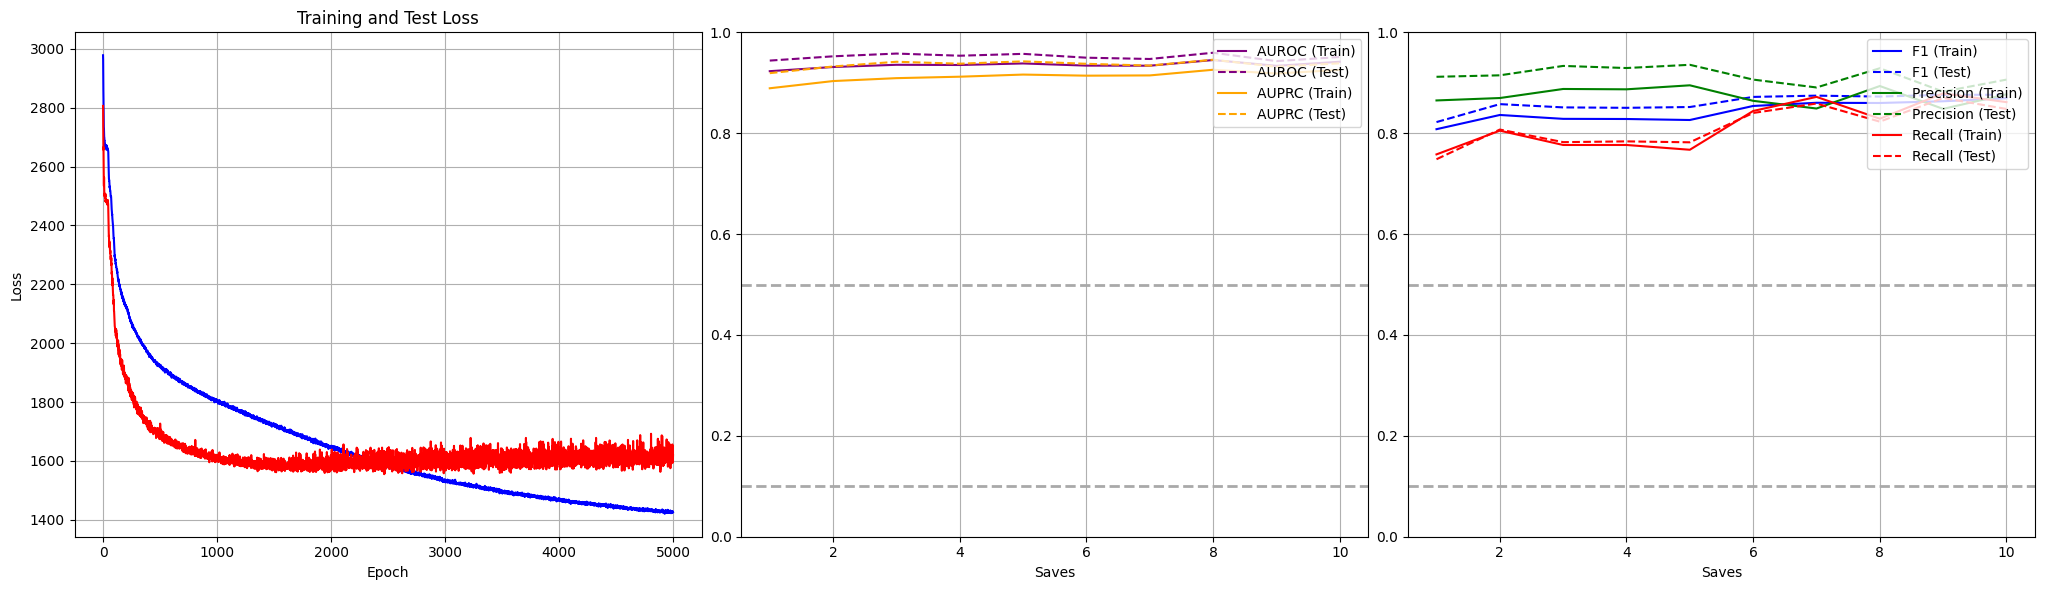

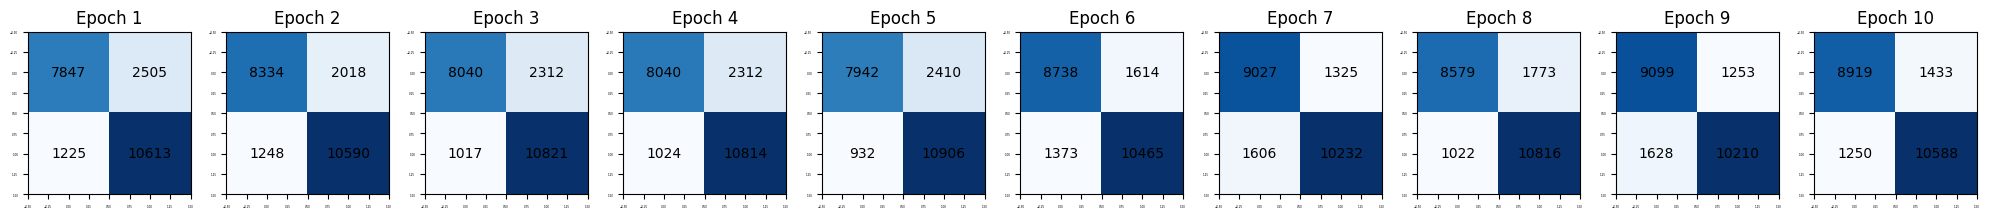

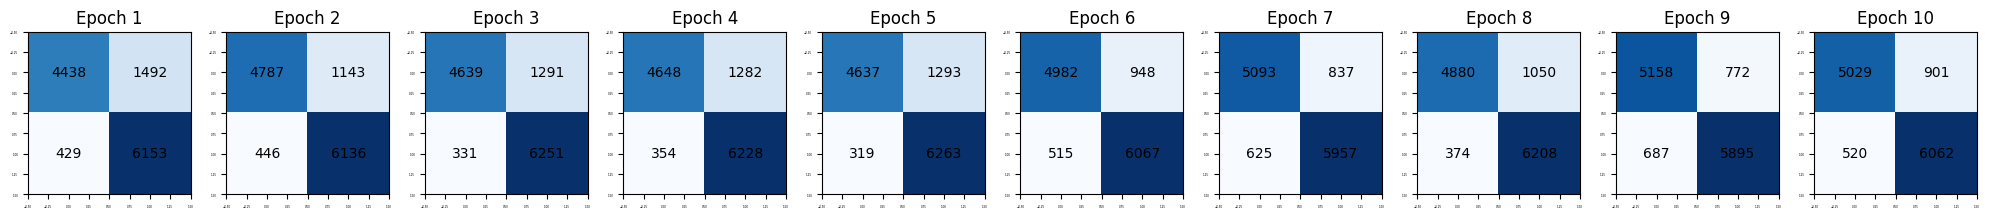

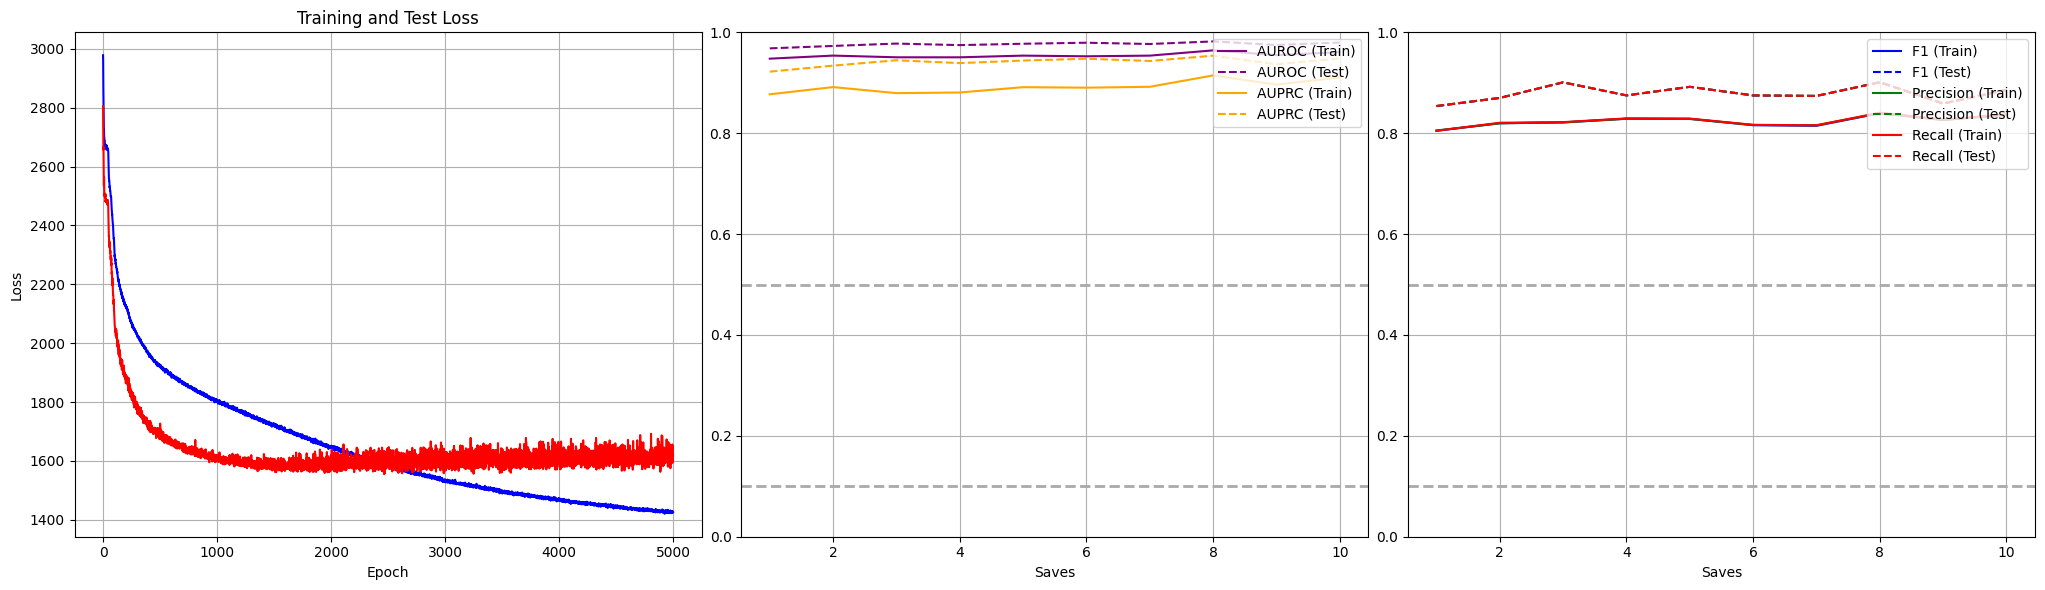

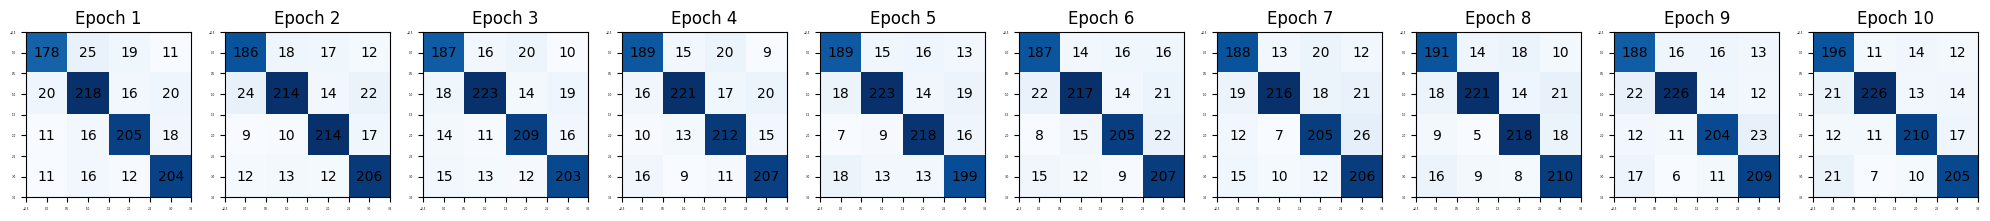

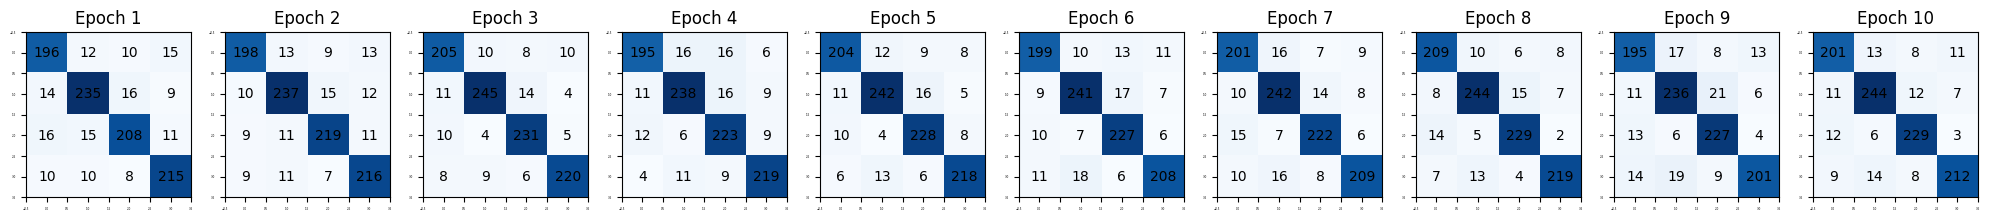

/home/jq2uw/.local/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


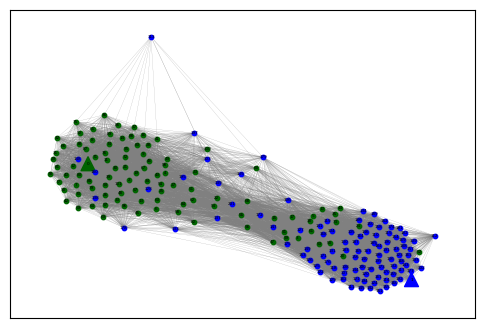

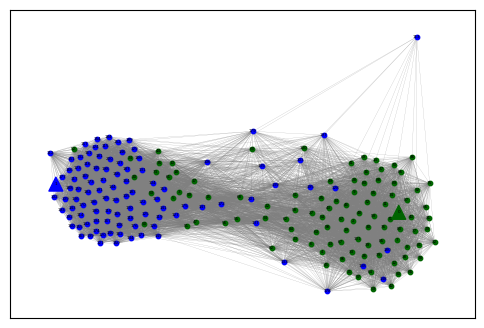

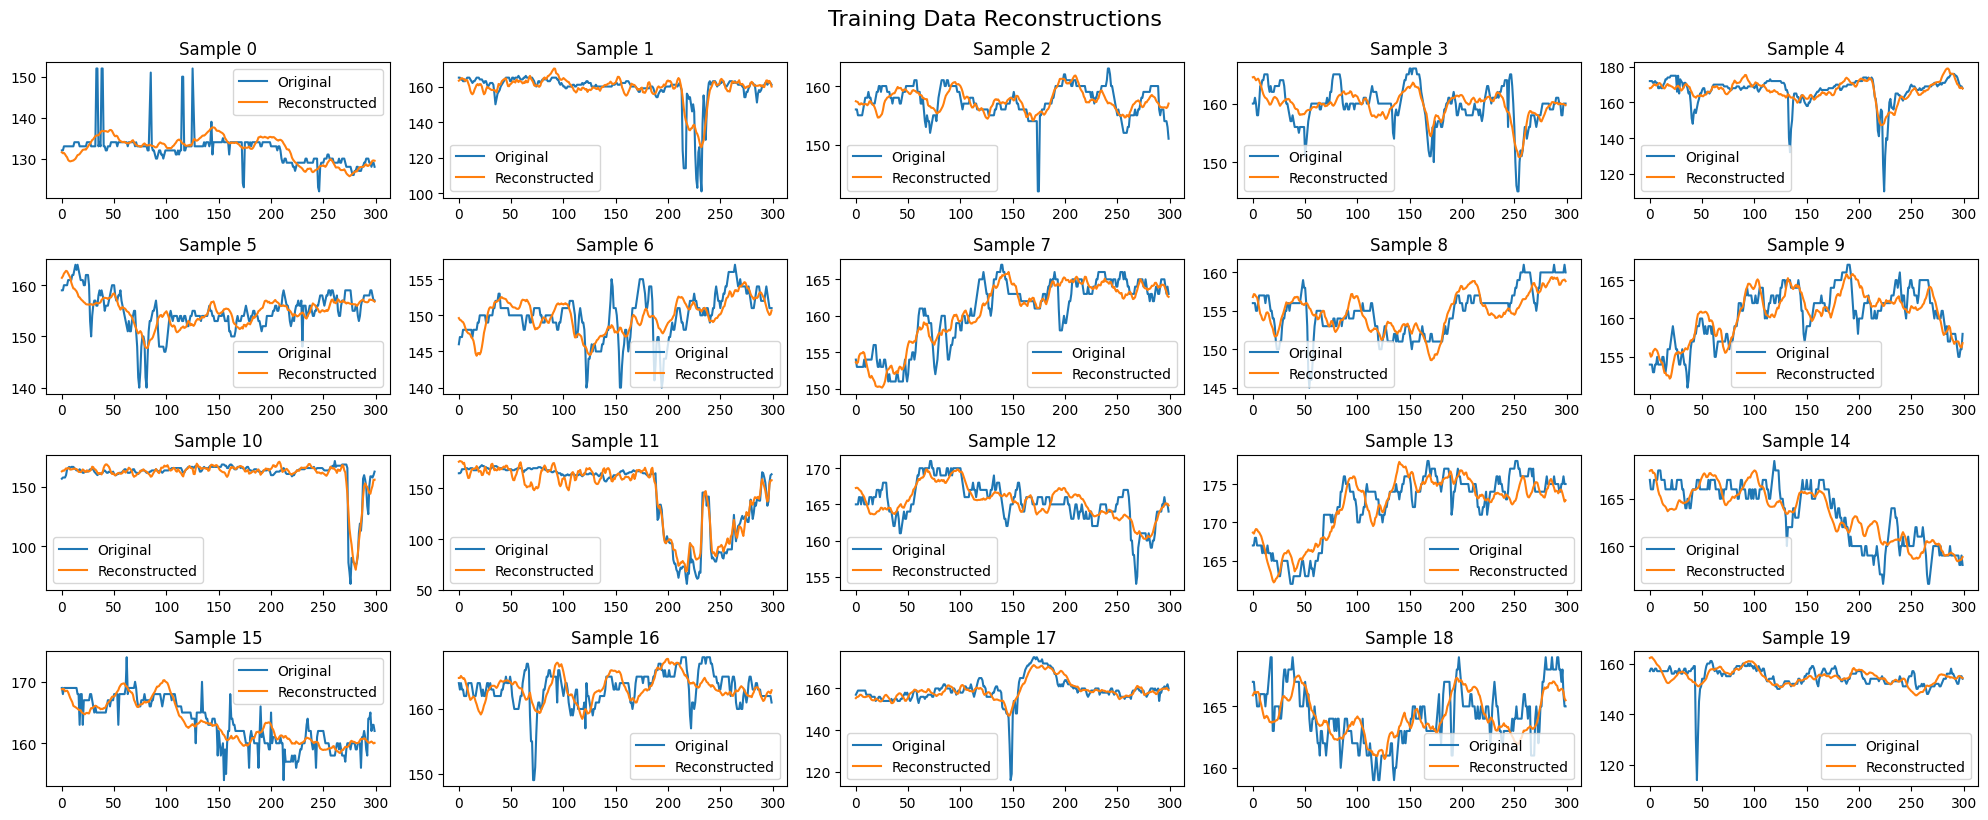

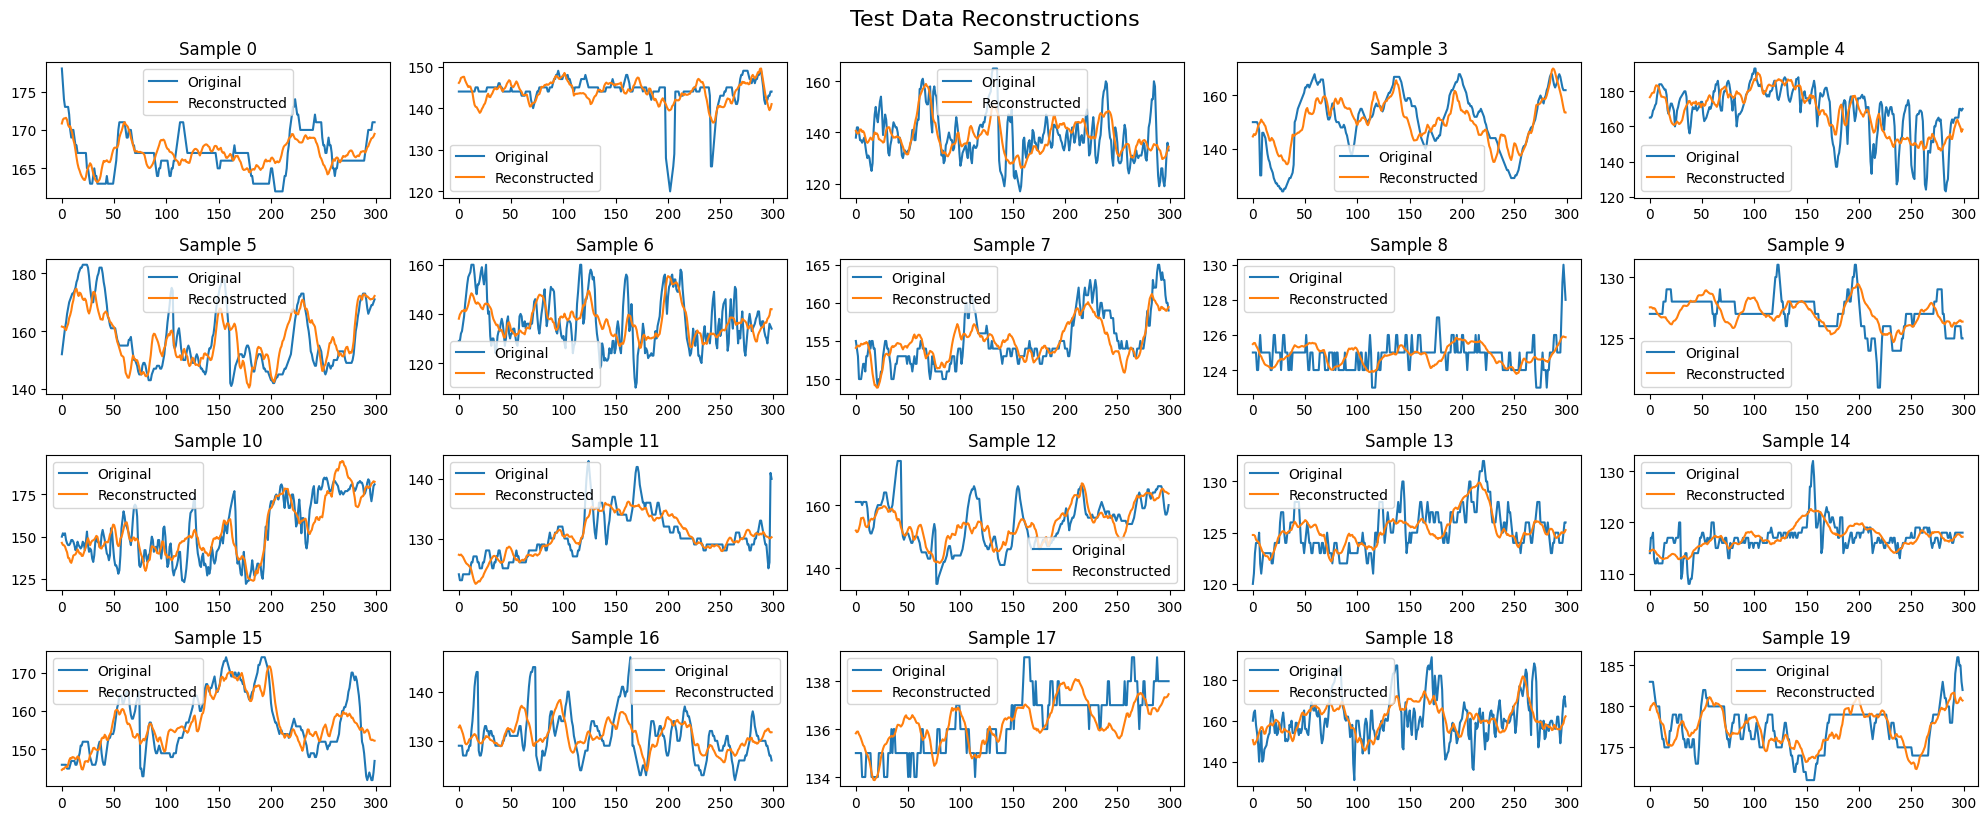

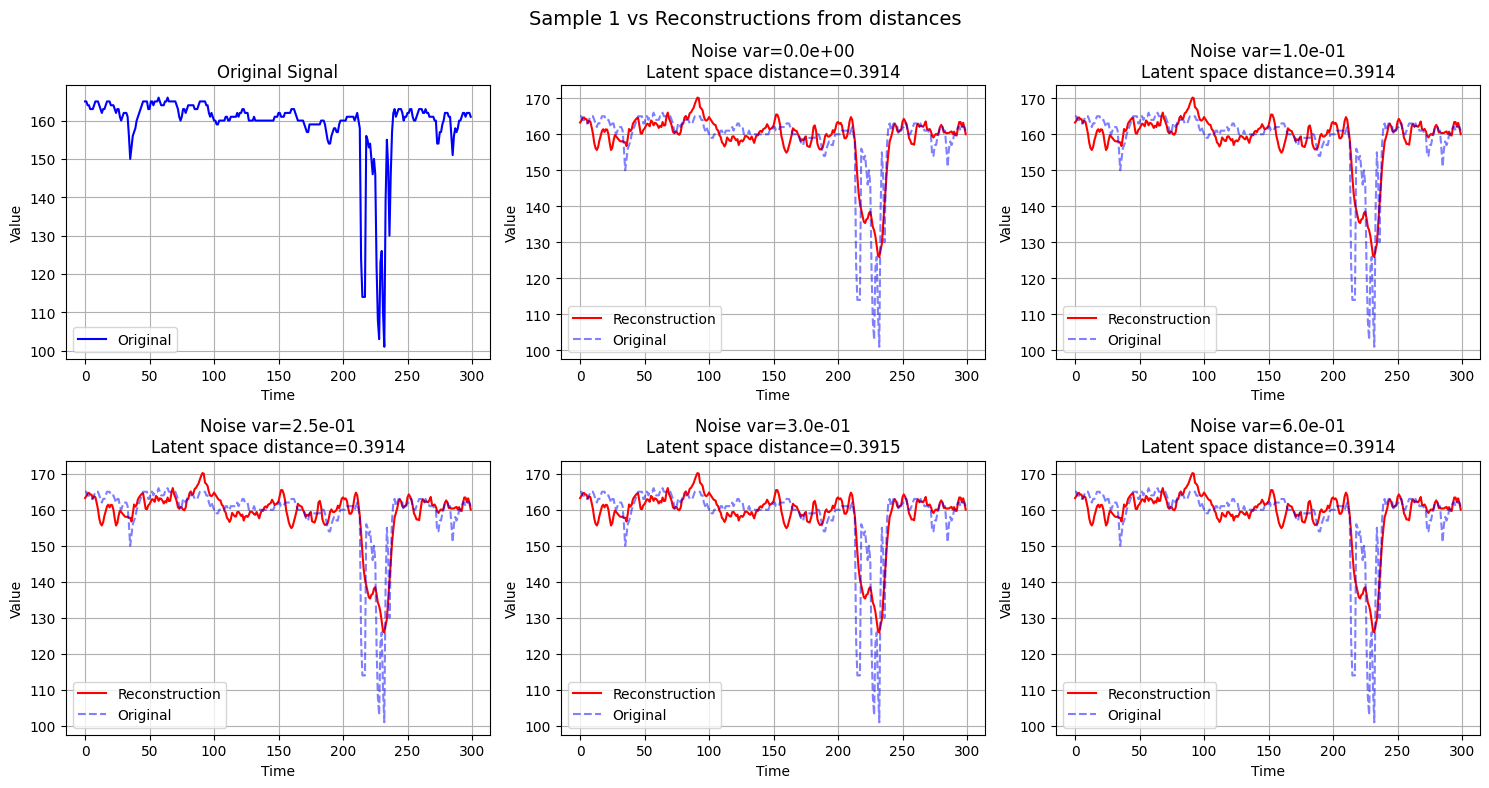

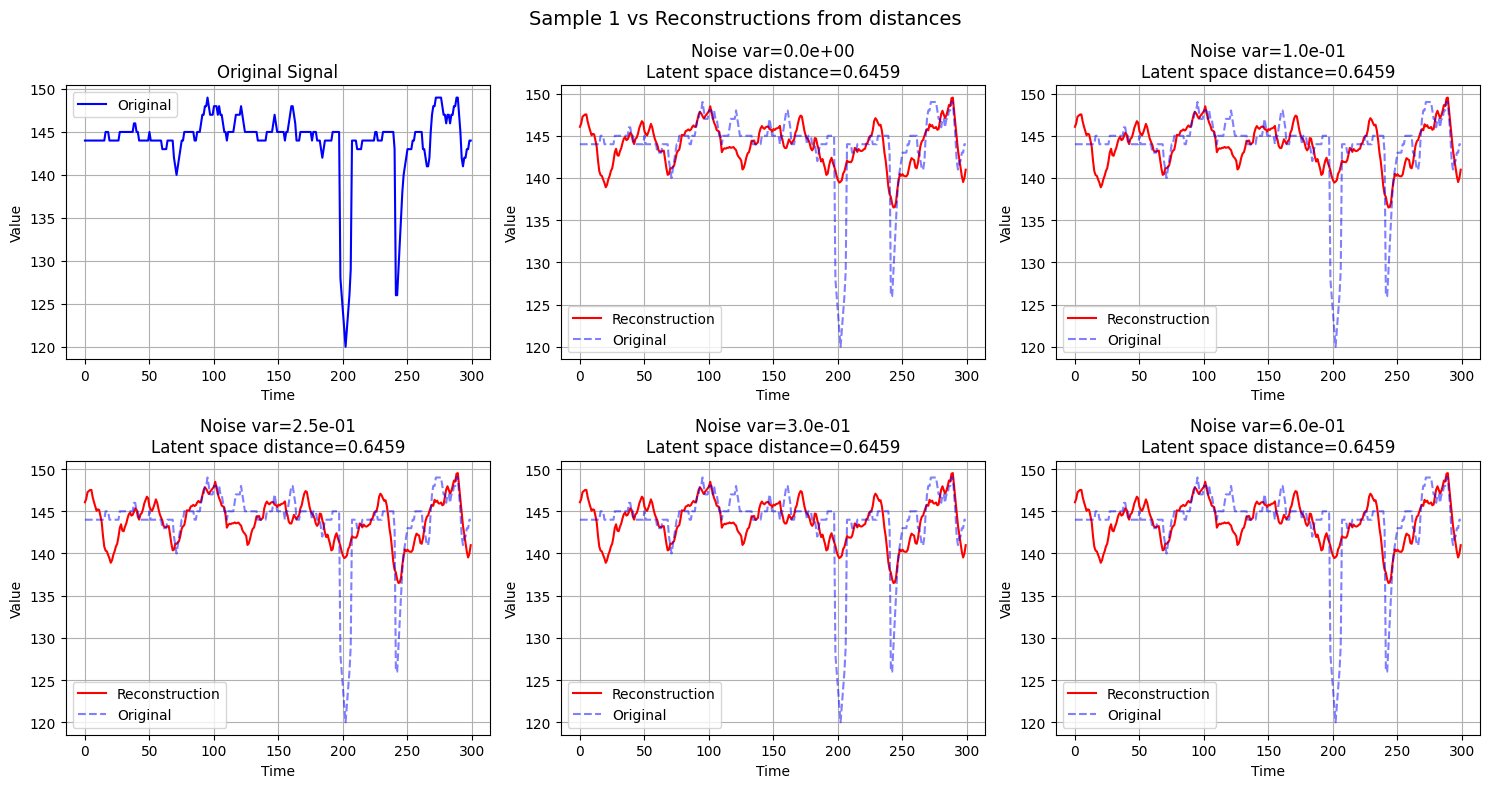

In [6]:
# overwrite = False
if overwrite or not os.path.exists(model_path):
    model.clip_mu = False

    # ------------------------- ready training for clip -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=500,      
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=0.0, 
                                epochs=10000) # for the first 1000 epochs, favor reconstruction more

    
    for i in range(10):  # config_dict['num_saves']
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs']*50, 
                                                        target_type = 'by_target',
                                                        train_type='joint',
                                                        alpha = 1/10)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save(eval_dict_ts2txt, output_dir+'/evals_clip_ts2txt.pth')
        torch.save(eval_dict_txt2ts, output_dir+'/evals_clip_txt2ts.pth')
    
        # print results 
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True, plot_confusion_matrices=True)
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)
        pairwise_distances, ts2tx_distances = net_emb(df_train, model, config_dict)
        # eval vae
        plot_reconstructions(model, 
                            df=df_train, 
                            config_dict = config_dict, 
                            text_col_ls = config_dict['text_col_ls'],
                            title="Training Data Reconstructions")

        plot_reconstructions(model, 
                            df=df_test, 
                            config_dict = config_dict, 
                            text_col_ls = config_dict['text_col_ls'],
                            title="Test Data Reconstructions")
        distances = [0, 0.1, 0.25, 0.3, 0.6]
        plot_reconstruction_from_distances(model, df_train, config_dict, text_col_ls = config_dict['text_col_ls'], distances = distances)
        plot_reconstruction_from_distances(model, df_test, config_dict, text_col_ls = config_dict['text_col_ls'], distances = distances)
    
        
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()
    
    # eval clip
    eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth', map_location=torch.device(device))
    eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth', map_location=torch.device(device))
    eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True, plot_confusion_matrices=True)
    eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)
    pairwise_distances, ts2tx_distances = net_emb(df_train, model, config_dict)
    
    # eval vae
    plot_reconstructions(model, 
                        df=df_train, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Training Data Reconstructions")

    plot_reconstructions(model, 
                        df=df_test, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Test Data Reconstructions")
    distances = [0, 0.1, 0.25, 0.3, 0.6]
    plot_reconstruction_from_distances(model, df_train, config_dict, text_col_ls = config_dict['text_col_ls'], distances = distances)
    plot_reconstruction_from_distances(model, df_test, config_dict, text_col_ls = config_dict['text_col_ls'], distances = distances)
    

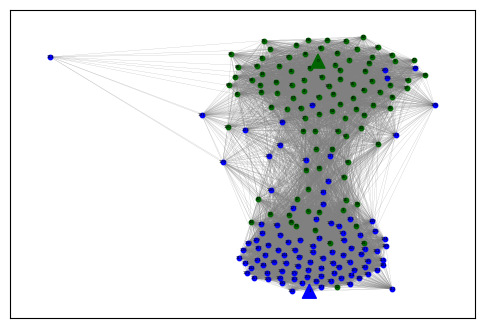

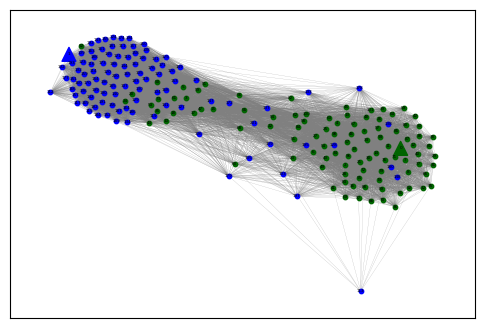

tensor(2.1486, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.4770, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1.6604, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.6375, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.9068, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1.2095, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1.2784, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.8477, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1.8988, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.5492, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.3877, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.5974, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1.2714, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.8421, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.6817, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1.6060, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.5200, device='cuda:0', grad_fn=<SelectBackward0

In [7]:
pairwise_distances, ts2tx_distances = net_emb(df_train, model, config_dict)
for i in range(95, 105):
    print(ts2tx_distances['simi']['High amount of consecutive increases.'][i])
    print(ts2tx_distances['simi']['Low amount of consecutive increases.'][i])

In [8]:
df_train_high = df_train[df_train['text'] == 'High amount of consecutive increases.'].reset_index(drop=True)
df_train_low = df_train[df_train['text'] == 'Low amount of consecutive increases.'].reset_index(drop=True)
df_test_high = df_test[df_test['text'] == 'High amount of consecutive increases.'].reset_index(drop=True)
df_test_low = df_test[df_test['text'] == 'Low amount of consecutive increases.'].reset_index(drop=True)


In [ ]:
for tid in range(10):

    df_infer = df_train_low.copy()
    df = df_infer.iloc[[tid]].copy()
    print(df['text'])

    df['text1'] = 'Low amount of consecutive increases.'
    df['text2'] = 'High amount of consecutive increases.'


    min_total_hats_lower = 500 # minimum total number of reconstructions per text
    highprob_hats_ratio = 0.1 # at least this ratio of reconstructions should have probability > 0.9
    highprob_th = 0.8
    for vr in range(0, 50000, 10):
        cts_hat, c_probs = vital3_contrast_infer(df, model, config_dict, text_cols = ['text1','text2'], var_ratio = vr, K = 5000)
        min_total_hats = min([len(v) for v in cts_hat.values()])
        min_highprob_hats = min([sum(probs > highprob_th) for probs in c_probs.values()])
        if min_total_hats > min_total_hats_lower and min_highprob_hats/min_total_hats > highprob_hats_ratio:
            print(vr)
            break
    
    ts = df.loc[:,'1':'300'].values[0]
    plot_vital_contrast_reconstructions(ts, cts_hat, c_probs)





    boot = 1000
    th = 0.75
    res = {}
    plt.figure(figsize=(6, 4))
    for txid, (text_condition, ts_hats) in enumerate(cts_hat.items()):
        probs = c_probs[text_condition]
        ts_hats = ts_hats[probs > th]
        probs = probs[probs > th]
        
        replace = ts_hats.shape[0] < boot
        idx = np.random.choice(ts_hats.shape[0], boot, replace=replace)
        ts_hats = ts_hats[idx]
        probs = probs[idx]
        probs = probs/sum(probs) # norm
        
        ui = []
        colors = ['blue', 'red']
        for j in range(len(ts_hats)):
            o = successive_increases(ts_hats[j].detach().cpu().numpy())
            p = probs[j].detach().cpu().numpy()
            u = round(o['uuu']*3*100, 2)#  + o['u']
            wu = p*u
            ui.append(u)
        res[text_condition] = ui
        plt.hist(ui, bins=15, alpha=0.5, label=f"Verbal instruction: {text_condition}")
        # add mean and median
        # plt.axvline(x=np.mean(ui), color='blue', linestyle='--')
        plt.axvline(x=np.median(ui), color=colors[txid], linestyle='--')
    plt.xlabel('Consecutive increases',fontsize=14)
    plt.legend(fontsize=10)
    plt.show()

0    Low amount of consecutive increases.
Name: text, dtype: object


In [ ]:
for tid in range(10):

    df_infer = df_train_high.copy()
    df = df_infer.iloc[[tid]].copy()
    print(df['text'])

    df['text1'] = 'Low amount of consecutive increases.'
    df['text2'] = 'High amount of consecutive increases.'


    min_total_hats_lower = 200 # minimum total number of reconstructions per text
    highprob_hats_ratio = 0.1 # at least this ratio of reconstructions should have probability > 0.9
    highprob_th = 0.8
    for vr in range(0, 50000, 100):
        cts_hat, c_probs = vital3_contrast_infer(df, model, config_dict, text_cols = ['text1','text2'], var_ratio = vr, K = 5000)
        min_total_hats = min([len(v) for v in cts_hat.values()])
        min_highprob_hats = min([sum(probs > highprob_th) for probs in c_probs.values()])
        if min_total_hats > min_total_hats_lower and min_highprob_hats/min_total_hats > highprob_hats_ratio:
            print(vr)
            break
    
    ts = df.loc[:,'1':'300'].values[0]
    plot_vital_contrast_reconstructions(ts, cts_hat, c_probs)





    boot = 1000
    th = 0#.75
    res = {}
    plt.figure(figsize=(6, 4))
    for txid, (text_condition, ts_hats) in enumerate(cts_hat.items()):
        probs = c_probs[text_condition]
        ts_hats = ts_hats[probs > th]
        probs = probs[probs > th]
        
        replace = ts_hats.shape[0] < boot
        idx = np.random.choice(ts_hats.shape[0], boot, replace=replace)
        ts_hats = ts_hats[idx]
        probs = probs[idx]
        probs = probs/sum(probs) # norm
        
        ui = []
        colors = ['blue', 'red']
        for j in range(len(ts_hats)):
            o = successive_increases(ts_hats[j].detach().cpu().numpy())
            p = probs[j].detach().cpu().numpy()
            u = round(o['uuu']*3*100, 2)#  + o['u']
            wu = p*u
            ui.append(u)
        res[text_condition] = ui
        plt.hist(ui, bins=15, alpha=0.5, label=f"Verbal instruction: {text_condition}")
        # add mean and median
        # plt.axvline(x=np.mean(ui), color='blue', linestyle='--')
        plt.axvline(x=np.median(ui), color=colors[txid], linestyle='--')
    plt.xlabel('Consecutive increases',fontsize=14)
    plt.legend(fontsize=10)
    plt.show()